In [56]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from matplotlib import pyplot as plt
# 导入数据处理和绘图的包
import pandas as pd
import matplotlib.pyplot as plt
# 随机森林相关的包
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from tqdm import tqdm
import itertools

In [46]:
# 读取数据
X_train = np.load('../data/X_train.npy')
# # 将数据转换为二维
X_train = X_train.reshape(X_train.shape[0], -1)
y_train = np.load('../data/y_train.npy')
X_test = np.load('../data/X_test.npy')
# 将数据转换为二维
X_test = X_test.reshape(X_test.shape[0], -1)
y_test = np.load('../data/y_test.npy')
# 查看数据的大小
print("训练集特征维数: ", X_train.shape)
print("训练集标签维数: ", y_train.shape)
print("测试集特征维数: ", X_test.shape)
print("测试集标签维数: ", y_test.shape)

# 由于是超额收益的分类问题, 因此将y大于y_train.mean()的标签设置为1，小于y_train.mean()的标签设置为0
train_mean_y = y_train.mean()
y_train[y_train > train_mean_y] = 1
y_train[y_train < train_mean_y] = 0
test_mean_y = y_test.mean()
y_test[y_test > test_mean_y] = 1
y_test[y_test < test_mean_y] = 0

训练集特征维数:  (11825, 270)
训练集标签维数:  (11825,)
测试集特征维数:  (4943, 270)
测试集标签维数:  (4943,)


In [47]:
# 构建随机森林模型
clf = RandomForestClassifier(random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)
# 在测试集上预测
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

In [48]:
# 在测试集上给出模型分类的效果
def evaluate(true, pred):
    print('accuracy:{:.2%}'.format(metrics.accuracy_score(true, pred)))
    print('precision:{:.2%}'.format(metrics.precision_score(true, pred)))
    print('recall:{:.2%}'.format(metrics.recall_score(true, pred)))
    print('f1-score:{:.2%}'.format(metrics.f1_score(true, pred)))

In [49]:
evaluate(y_test, y_pred)

accuracy:53.17%
precision:41.54%
recall:24.88%
f1-score:31.12%


为270个特征设定名字

In [50]:
# 为270个特征设定名字
feature_names = ['open', 'high', 'low', 'close', 'vwap', 'volume', 'return1', 'turn', 'free_turn']
time = range(29, -1, -1)
all_feature_names = []
for i in feature_names:
    for j in time:
        all_feature_names.append(i + '_' + str(j))

In [51]:
feat_importances = pd.Series(clf.feature_importances_, index=all_feature_names)

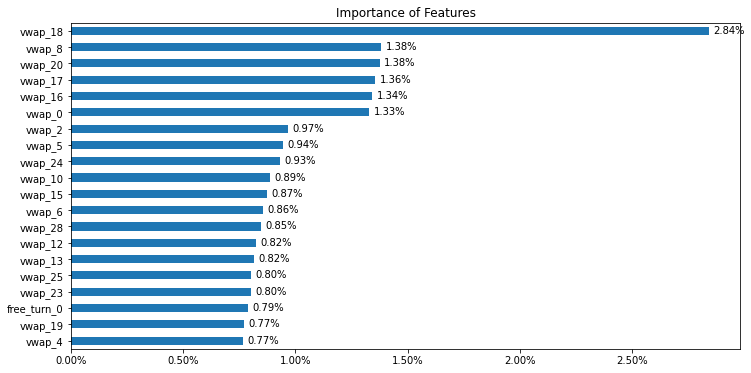

In [52]:
# 将特征重要性排序后绘图
ax = feat_importances.sort_values()[250:].plot(kind='barh', figsize=(12, 6))
# 设置横坐标格式
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "{:.2%}".format(x)))
# 设置标题
ax.set_title('Importance of Features')
# 如果不需要显示特征重要性的大小数值，可以使用下面2行代码
# for container in ax.containers:
#     ax.bar_label(container)
# 如果需要显示特征重要性的大小数值，可以使用下面的代码
x_offset = 0
y_offset = 0
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2%}".format(b.x1)
    ax.annotate(val, (b.x1 + 0.0002, b.y1 - 0.4))

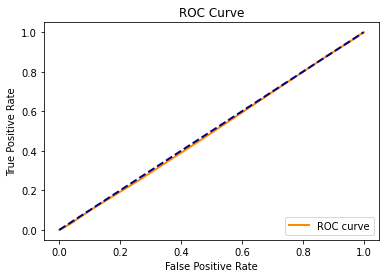

In [53]:
# 绘制ROC曲线
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [63]:
# 绘制混淆矩阵
y_pred = np.where(y_pred > 0.5, 1, 0)
# 只截取最后943个样本的预测结果
y_pred = y_pred[-943:]
y_test = y_test[-943:]
cm = metrics.confusion_matrix(y_test, y_pred)

In [64]:
cm

array([[655, 181],
       [ 89,  18]])

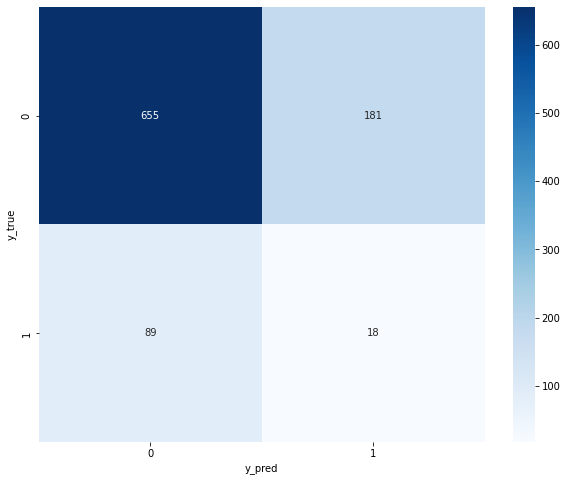

In [65]:
import seaborn as sn
plt.figure(figsize = (10,8))
sn.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()